In [ ]:
# XGBoost Classifier with TF-IDF + Semantic Similarity Features

In [5]:
# Imports
!pip install datasets
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [6]:
#Loading the dataset from hugging face
!pip install datasets
#loading the dataset
dataset = load_dataset("cnamuangtoun/resume-job-description-fit")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv:   0%|          | 0.00/53.4M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1759 [00:00<?, ? examples/s]

In [7]:
train = dataset['train']
test = dataset['test']
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

# Preprocessing
def preprocess_text(text):
    return text.lower().strip()

train_data['resume_text'] = train_data['resume_text'].apply(preprocess_text)
train_data['job_description_text'] = train_data['job_description_text'].apply(preprocess_text)
test_data['resume_text'] = test_data['resume_text'].apply(preprocess_text)
test_data['job_description_text'] = test_data['job_description_text'].apply(preprocess_text)


In [8]:
# TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
train_combined_text = (train_data['resume_text'] + " " + train_data['job_description_text']).tolist()
test_combined_text = (test_data['resume_text'] + " " + test_data['job_description_text']).tolist()
X_tfidf_train = vectorizer.fit_transform(train_combined_text)
X_tfidf_test = vectorizer.transform(test_combined_text)

In [9]:

# Semantic similarity scores using Sentence-BERT
embedder = SentenceTransformer('all-MiniLM-L6-v2')
resume_embeds = embedder.encode(test_data['resume_text'].tolist(), convert_to_tensor=False)
jd_embeds = embedder.encode(test_data['job_description_text'].tolist(), convert_to_tensor=False)
similarity_scores = np.diag(cosine_similarity(resume_embeds, jd_embeds)).reshape(-1, 1)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:

# Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])


In [11]:

# Combine features: TF-IDF + Semantic Similarity
X_combined_train = np.hstack([X_tfidf_train.toarray(), np.zeros((X_tfidf_train.shape[0], 1))])  # padded train
X_combined_test = np.hstack([X_tfidf_test.toarray(), similarity_scores])  # test + similarity


In [12]:

# Train XGBoost model
dtrain = xgb.DMatrix(X_combined_train, label=y_train)
dtest = xgb.DMatrix(X_combined_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': len(label_encoder.classes_),
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'eta': 0.3,
    'seed': 42
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict and evaluate
y_pred = xgb_model.predict(dtest).astype(int)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


               precision    recall  f1-score   support

     Good Fit       0.47      0.26      0.34       458
       No Fit       0.57      0.77      0.66       857
Potential Fit       0.35      0.28      0.31       444

     accuracy                           0.51      1759
    macro avg       0.46      0.44      0.43      1759
 weighted avg       0.49      0.51      0.49      1759

Confusion Matrix:
[[120 213 125]
 [ 95 660 102]
 [ 42 278 124]]


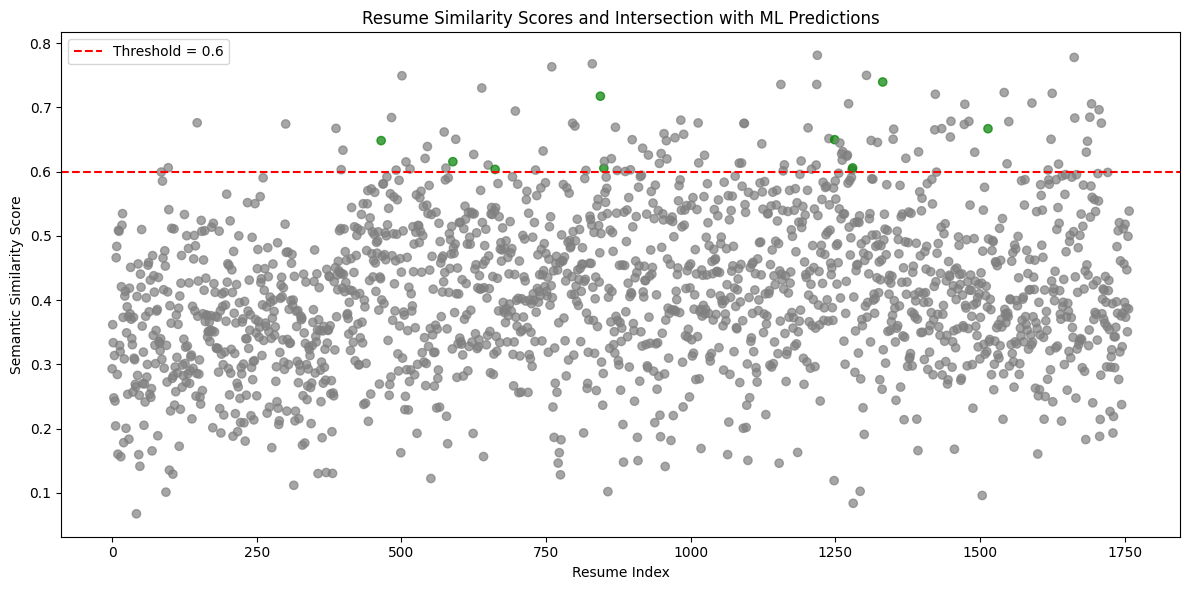

In [17]:
# Example: define threshold first
threshold = 0.6
similarity_matrix = cosine_similarity(resume_embeds, jd_embeds)
diagonal_scores = np.diag(similarity_matrix)

ml_predictions = xgb_model.predict(xgb.DMatrix(X_combined_test))
ml_labels = label_encoder.inverse_transform(ml_predictions.astype(int))

# Define a threshold (if not yet defined)
threshold = 0.6

# Build intersection: cases classified as 'Good Fit' AND have high similarity
intersection_indices = [
    i for i, (label, score) in enumerate(zip(ml_labels, diagonal_scores))
    if label == 'Good Fit' and score >= threshold
]
# Prepare color: green for intersection, gray otherwise
colors = ['green' if i in intersection_indices else 'gray' for i in range(len(diagonal_scores))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(diagonal_scores)), diagonal_scores, c=colors, alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Resume Index')
plt.ylabel('Semantic Similarity Score')
plt.title('Resume Similarity Scores and Intersection with ML Predictions')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
print(f"Strong semantic + ML Good Fit matches: {len(intersection_indices)} out of {len(test_data)}")
for i in intersection_indices[:5]:
    print(f"\nSimilarity: {diagonal_scores[i]:.2f}")
    print(f"Resume:\n{test_data.iloc[i]['resume_text'][:300]}")
    print(f"JD:\n{test_data.iloc[i]['job_description_text'][:300]}")

Strong semantic + ML Good Fit matches: 9 out of 1759

Similarity: 0.65
Resume:
summarydata engineeringwith experience in design, development, implementation and support ofdata warehousingfor over8 years. experienced in completesoftware development life cycle (sdlc),software testing life cycle (stlc),sdlc methodologies. extensively worked oninformatica designer tools(source ana
JD:
role: lead data engineerlocation: remoteduration: long term 8 to 10 years of experience working in data engineering, business intelligence or related field delivering large scale data platforms and services. ideal candidate will have the following skills: a successful history of manipulating, proces

Similarity: 0.62
Resume:
career overviewexpert level user interface front end web developer with high-quality skills, professional attitude, and conscientious commitment looking to give star-quality work to a company that cultivates an environment of creativity, caring, fun and professionalism.
qualificationsweb 